#Importing Dependencies

In [1]:
!git clone https://github.com/Vedant336Neekhra/Style_Swap_Requirements
!pip install ninja
!pip install git+https://github.com/openai/CLIP.git
!pip install git+https://github.com/facebookresearch/detectron2.git
!pip install av

Cloning into 'Style_Swap_Requirements'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (315/315), done.
remote: Compressing objects: 100% (312/312), done.
remote: Total 315 (delta 100), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (315/315), 6.69 MiB | 9.40 MiB/s, done.
Resolving deltas: 100% (100/100), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 4.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-99p9bbi1
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-99p9bbi1
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 1.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1

In [2]:
import sys
 # Adjust the path as necessary
sys.path.append('/content/Style_Swap_Requirements')

In [3]:
import ninja
from google.colab import drive
import sys
import cv2
import torchvision.transforms as transforms
from stylegan.generator import Generator
import torch.optim as optim
from PIL import Image
from CLIP_for_FICE.CLIP_for_FICE import CLIP
from torchvision.utils import save_image
from IPython.display import Image, display
import os
import torch
import numpy as np
from segmentation_model import semantic_loss
from segmentation_model import for_model
from segmentation_model import SegModel
import warnings
import matplotlib.pyplot as plt
import zipfile
import gdown
from e4e import load_e4e
import torch.nn.functional as F
from densepose.model import DenseNet, set_instances

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
%cd /content/Style_Swap_Requirements

/content/Style_Swap_Requirements


Downloading the checkpoints for the models we trained


In [6]:
file_id = '1V2e3q9wU-IcfyLJ5qoLfDNrCjaxgd2tY'
destination = 'checkpoints.zip'
gdown.download(f'https://drive.google.com/uc?id={file_id}', destination, quiet=False)
with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('checkpoints')

Downloading...
From (original): https://drive.google.com/uc?id=1V2e3q9wU-IcfyLJ5qoLfDNrCjaxgd2tY
From (redirected): https://drive.google.com/uc?id=1V2e3q9wU-IcfyLJ5qoLfDNrCjaxgd2tY&confirm=t&uuid=7043ce4d-6fb5-43b8-af85-afeda4447417
To: /content/Style_Swap_Requirements/checkpoints.zip
100%|██████████| 1.68G/1.68G [00:36<00:00, 46.3MB/s]


## initialising different models we are gonna use

In [13]:
densepose_model = DenseNet().to(device)
e4e_model = load_e4e('/content/Style_Swap_Requirements/checkpoints/checkpoints/e4e.pt').to(device)
Seg_Model = SegModel('/content/Style_Swap_Requirements/checkpoints/checkpoints/segmentator.pt').to(device)
clip =CLIP().to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to 

## defining useful functions to use with our models

In [23]:
def make_latent_code(model,image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    tensor_image = transform(image).to(device)
    out = model(tensor_image.view(1,3,256,256))
    return out

In [15]:
def w_regularization_loss(latent_code):
    N = latent_code.shape[1]
    initial_latent_vector = latent_code[:,0,:].view(-1,1,512)
    w_ref = initial_latent_vector.repeat(1,N-1,1)
    w_tar = latent_code[:,1:,:]
    loss = F.mse_loss(w_ref, w_tar, reduction='none')
    loss = loss.mean((1, 2)).sum()
    return loss

In [16]:
def clip_similarity(model, imgs, text_feats):
    img_features = model.encode_image(imgs)
    clip_similarity = model.compute_similarity(img_features, text_feats)
    return clip_similarity

In [17]:
def densenet_forward(model, imgs):
    bs = imgs.size(0)
    box = torch.tensor([[0, 0, 256, 256]], device=imgs.device)
    instances = set_instances(box, bs)
    body = model(imgs, instances)
    return body

## Main training loop

In [18]:
checkpoint = torch.load('/content/Style_Swap_Requirements/checkpoints/checkpoints/model.pt')
def train_styleclip(generator, text_prompt, num_epochs, learning_rate, device, image_path, clip_w, img_w, reg_w, body_shape_w,head_w,stitch):
    torch.autograd.set_detect_anomaly(True)
    generator.train(False)
    latent_code = make_latent_code(e4e_model,image_path).to(device)
    latent_code.requires_grad = True
    optimizer = optim.Adam([latent_code], lr=learning_rate)

    losses = []
    with torch.no_grad():
      text_feats = clip.encode_text(text_prompt).view(1, -1)
      shape_real = densenet_forward(densepose_model, for_model(image_path).to(device))
      real_bg, real_body, real_head = Seg_Model(for_model(image_path).to(device))
    blend_mask = 1 - real_head

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for epoch in range(num_epochs):
            warnings.filterwarnings("ignore", module='semantic_loss')
            warnings.filterwarnings("ignore", module='for_model')
            warnings.filterwarnings("ignore", message="Setting up PyTorch plugin 'upfirdn2d_plugin'... Failed!")
            optimizer.zero_grad()
            img = generator.synthesis(latent_code)
            if torch.isnan(img).any():
              print(f"NaN detected in generated image at epoch {epoch}")
              break
            body_shape = densenet_forward(densepose_model,img)
            body_shape_loss = F.mse_loss(shape_real, body_shape, reduction='none').mean((1,2,3)).sum()
            clip_sim = clip_similarity(clip,img, text_feats)
            clip_loss = (1 - clip_sim).sum()
            image_loss, head_loss = semantic_loss('/content/Style_Swap_Requirements/checkpoints/checkpoints/segmentator.pt',img,image_path,device)
            reg_loss = w_regularization_loss(latent_code)
            net_loss = clip_w*clip_loss + head_loss*head_w + img_w*image_loss + reg_w*reg_loss + body_shape_loss*body_shape_w
            losses.append(net_loss.item())
            net_loss.backward(retain_graph=True)
            if torch.isnan(net_loss).any():
                print(f"NaN detected in net_loss at epoch {epoch}")
                break
            optimizer.step()
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {net_loss.item()}")
            if epoch%10==0:
              final_image = generator.synthesis(latent_code)
              if stitch:
                  final_image = blend_mask*final_image + (1-blend_mask)*(for_model(image_path).to(device))  # Image Stitching
              save_image(final_image, f"epoch_{epoch}.png", normalize=True)
              display(Image(f"epoch_{epoch}.png"))

    final_image = generator.synthesis(latent_code)
    if stitch:
        final_image = blend_mask*final_image + (1-blend_mask)*(for_model(image_path).to(device))  # Image Stitching

    final_name = f"Clip_W={clip_w},Img_W={img_w},Reg_W={reg_w},Stitch={stitch},Epochs={num_epochs},lr={learning_rate},{text_prompt}".replace('.',',')
    final_name += '.png'
    save_image(final_image, final_name, normalize=True)
    print("Training complete")
    plt.subplot(1,2,1)
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Original Image')
    plt.subplot(1,2,2)
    plt.imshow(cv2.cvtColor(cv2.imread(final_name), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(text_prompt)
    plt.tight_layout()
    plt.show()

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'{num_epochs} Epochs')
    plt.show()

In [20]:
def main(num_epochs, lr, clip_w, img_w, reg_w,body_shape_w,head_w, stitch, image_path, text_prompt):
    generator = Generator(
        z_dim= 512,
        w_dim= 512,
        mapping_kwargs= {'num_layers': 2},
        synthesis_kwargs= {'channel_base': 16384,'channel_max': 512,'num_fp16_res': 4,'conv_clamp': 256},
        c_dim= 0,
        img_resolution= 256,
        img_channels= 3) # Adjust parameters as needed
    generator.load_state_dict(checkpoint['G'])
    generator = generator.to(device)
    train_styleclip(generator, text_prompt, num_epochs, lr, device,image_path, clip_w, img_w, reg_w,body_shape_w,head_w, stitch)

## Results

Epoch 1/500, Loss: 2.911952018737793


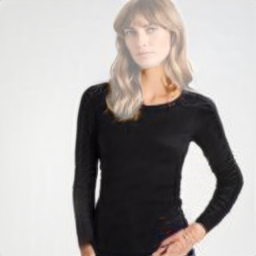

Epoch 2/500, Loss: 2.0097362995147705
Epoch 3/500, Loss: 1.4975032806396484
Epoch 4/500, Loss: 1.3237264156341553
Epoch 5/500, Loss: 1.3378880023956299
Epoch 6/500, Loss: 1.2952461242675781
Epoch 7/500, Loss: 1.2342603206634521
Epoch 8/500, Loss: 1.1916545629501343
Epoch 9/500, Loss: 1.1826260089874268
Epoch 10/500, Loss: 1.1699241399765015
Epoch 11/500, Loss: 1.1649272441864014


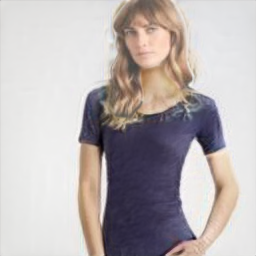

Epoch 12/500, Loss: 1.1543290615081787
Epoch 13/500, Loss: 1.1495072841644287
Epoch 14/500, Loss: 1.1336584091186523
Epoch 15/500, Loss: 1.128031849861145
Epoch 16/500, Loss: 1.1131765842437744
Epoch 17/500, Loss: 1.1008368730545044
Epoch 18/500, Loss: 1.086173415184021
Epoch 19/500, Loss: 1.0689400434494019
Epoch 20/500, Loss: 1.0576276779174805
Epoch 21/500, Loss: 1.0445549488067627


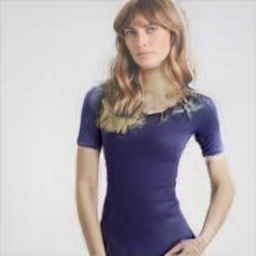

Epoch 22/500, Loss: 1.0299711227416992
Epoch 23/500, Loss: 1.0191971063613892
Epoch 24/500, Loss: 1.0119123458862305
Epoch 25/500, Loss: 1.0033165216445923
Epoch 26/500, Loss: 0.9973640441894531
Epoch 27/500, Loss: 0.9918303489685059
Epoch 28/500, Loss: 0.981510579586029
Epoch 29/500, Loss: 0.968732476234436
Epoch 30/500, Loss: 0.9599762558937073
Epoch 31/500, Loss: 0.9540429711341858


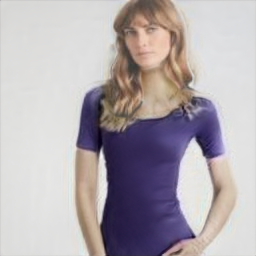

Epoch 32/500, Loss: 0.949286937713623
Epoch 33/500, Loss: 0.9443709850311279
Epoch 34/500, Loss: 0.9380724430084229
Epoch 35/500, Loss: 0.9321847558021545
Epoch 36/500, Loss: 0.9217135906219482
Epoch 37/500, Loss: 0.9174528121948242
Epoch 38/500, Loss: 0.9057316780090332
Epoch 39/500, Loss: 0.9033188819885254
Epoch 40/500, Loss: 0.8992938995361328
Epoch 41/500, Loss: 0.8924189805984497


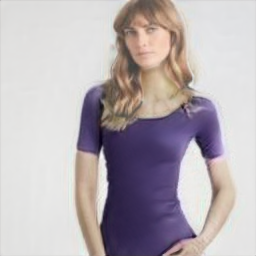

Epoch 42/500, Loss: 0.8831703066825867
Epoch 43/500, Loss: 0.8812888860702515
Epoch 44/500, Loss: 0.8739926218986511
Epoch 45/500, Loss: 0.8691517114639282
Epoch 46/500, Loss: 0.8676828145980835
Epoch 47/500, Loss: 0.8710070252418518
Epoch 48/500, Loss: 0.8631811141967773
Epoch 49/500, Loss: 0.8610694408416748
Epoch 50/500, Loss: 0.8558956384658813
Epoch 51/500, Loss: 0.8526853322982788


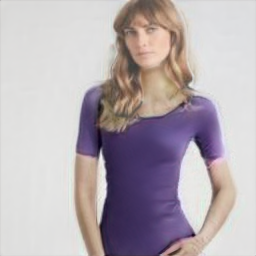

Epoch 52/500, Loss: 0.8476855754852295
Epoch 53/500, Loss: 0.8445761799812317
Epoch 54/500, Loss: 0.8409690260887146
Epoch 55/500, Loss: 0.8350263833999634
Epoch 56/500, Loss: 0.8326808214187622
Epoch 57/500, Loss: 0.835146427154541
Epoch 58/500, Loss: 0.8242825865745544
Epoch 59/500, Loss: 0.8259186744689941
Epoch 60/500, Loss: 0.8221442103385925
Epoch 61/500, Loss: 0.8095718622207642


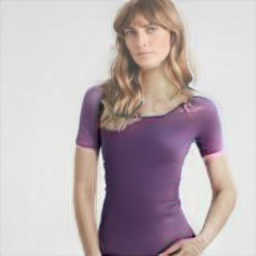

Epoch 62/500, Loss: 0.8133905529975891
Epoch 63/500, Loss: 0.8057369589805603
Epoch 64/500, Loss: 0.8004259467124939
Epoch 65/500, Loss: 0.7938029766082764
Epoch 66/500, Loss: 0.7898009419441223
Epoch 67/500, Loss: 0.7869431376457214
Epoch 68/500, Loss: 0.7803031206130981
Epoch 69/500, Loss: 0.7742799520492554
Epoch 70/500, Loss: 0.766288161277771
Epoch 71/500, Loss: 0.7646716833114624


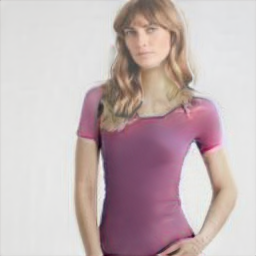

Epoch 72/500, Loss: 0.7613776922225952
Epoch 73/500, Loss: 0.7605154514312744
Epoch 74/500, Loss: 0.7627360224723816
Epoch 75/500, Loss: 0.7643563151359558
Epoch 76/500, Loss: 0.7561927437782288
Epoch 77/500, Loss: 0.7482175230979919
Epoch 78/500, Loss: 0.7447952628135681
Epoch 79/500, Loss: 0.7407916784286499
Epoch 80/500, Loss: 0.742470920085907
Epoch 81/500, Loss: 0.7383924722671509


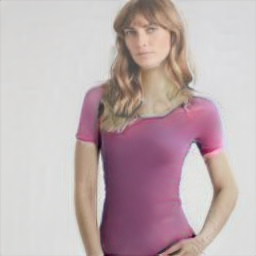

Epoch 82/500, Loss: 0.7416206002235413
Epoch 83/500, Loss: 0.7306511998176575
Epoch 84/500, Loss: 0.7277314066886902
Epoch 85/500, Loss: 0.7338665127754211
Epoch 86/500, Loss: 0.734822154045105
Epoch 87/500, Loss: 0.7299465537071228
Epoch 88/500, Loss: 0.7220211625099182
Epoch 89/500, Loss: 0.7311609983444214
Epoch 90/500, Loss: 0.7255409359931946
Epoch 91/500, Loss: 0.7272693514823914


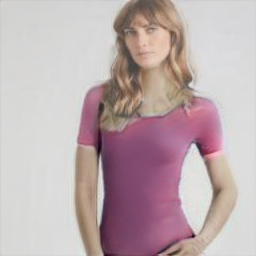

Epoch 92/500, Loss: 0.7191657423973083
Epoch 93/500, Loss: 0.7165005803108215
Epoch 94/500, Loss: 0.7144086956977844
Epoch 95/500, Loss: 0.7170276641845703
Epoch 96/500, Loss: 0.7109610438346863
Epoch 97/500, Loss: 0.7105068564414978
Epoch 98/500, Loss: 0.7068641781806946
Epoch 99/500, Loss: 0.6991755962371826
Epoch 100/500, Loss: 0.6978633999824524
Epoch 101/500, Loss: 0.6996092200279236


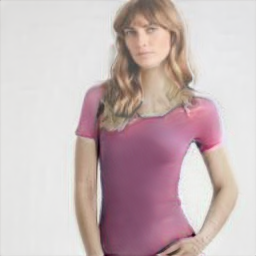

Epoch 102/500, Loss: 0.6999313235282898
Epoch 103/500, Loss: 0.6931005716323853
Epoch 104/500, Loss: 0.6939605474472046
Epoch 105/500, Loss: 0.6926008462905884
Epoch 106/500, Loss: 0.6936034560203552
Epoch 107/500, Loss: 0.6983289122581482
Epoch 108/500, Loss: 0.7015119194984436
Epoch 109/500, Loss: 0.6943402290344238
Epoch 110/500, Loss: 0.6928164958953857
Epoch 111/500, Loss: 0.6863950490951538


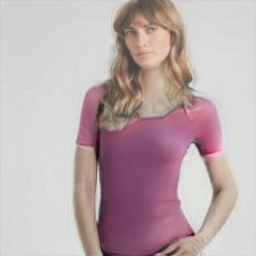

Epoch 112/500, Loss: 0.6922658085823059
Epoch 113/500, Loss: 0.6787972450256348
Epoch 114/500, Loss: 0.6856170296669006
Epoch 115/500, Loss: 0.6943526268005371
Epoch 116/500, Loss: 0.7002231478691101
Epoch 117/500, Loss: 0.6915186643600464
Epoch 118/500, Loss: 0.6798073649406433
Epoch 119/500, Loss: 0.6882266402244568
Epoch 120/500, Loss: 0.6789162755012512
Epoch 121/500, Loss: 0.6765337586402893


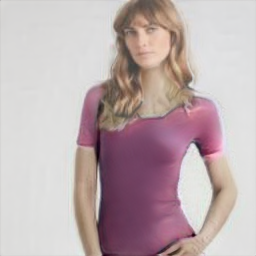

Epoch 122/500, Loss: 0.6775718927383423
Epoch 123/500, Loss: 0.6728320121765137
Epoch 124/500, Loss: 0.6821888089179993
Epoch 125/500, Loss: 0.6899778842926025
Epoch 126/500, Loss: 0.6787382960319519
Epoch 127/500, Loss: 0.671908974647522
Epoch 128/500, Loss: 0.6715218424797058
Epoch 129/500, Loss: 0.6673897504806519
Epoch 130/500, Loss: 0.6665301322937012
Epoch 131/500, Loss: 0.6776071786880493


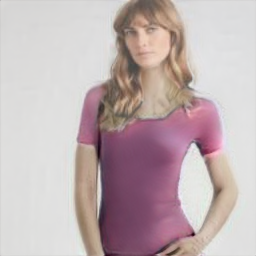

Epoch 132/500, Loss: 0.6803973317146301
Epoch 133/500, Loss: 0.6783576011657715
Epoch 134/500, Loss: 0.6712682843208313
Epoch 135/500, Loss: 0.6680205464363098
Epoch 136/500, Loss: 0.6606053113937378
Epoch 137/500, Loss: 0.6675930619239807
Epoch 138/500, Loss: 0.6643591523170471
Epoch 139/500, Loss: 0.6631883382797241
Epoch 140/500, Loss: 0.6611934304237366
Epoch 141/500, Loss: 0.656319260597229


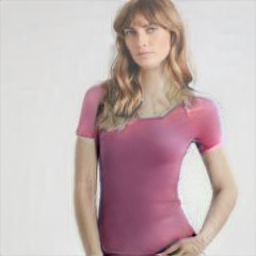

Epoch 142/500, Loss: 0.651563286781311
Epoch 143/500, Loss: 0.6528893113136292
Epoch 144/500, Loss: 0.6512913703918457
Epoch 145/500, Loss: 0.6513798236846924
Epoch 146/500, Loss: 0.6502225995063782
Epoch 147/500, Loss: 0.6493936777114868
Epoch 148/500, Loss: 0.6542373299598694
Epoch 149/500, Loss: 0.6539854407310486
Epoch 150/500, Loss: 0.654765784740448
Epoch 151/500, Loss: 0.6567295789718628


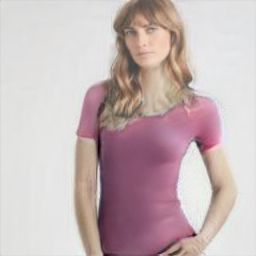

Epoch 152/500, Loss: 0.6586594581604004
Epoch 153/500, Loss: 0.6670499444007874
Epoch 154/500, Loss: 0.6558430790901184
Epoch 155/500, Loss: 0.6617114543914795
Epoch 156/500, Loss: 0.6509745717048645
Epoch 157/500, Loss: 0.653240978717804
Epoch 158/500, Loss: 0.6483502388000488
Epoch 159/500, Loss: 0.6433202624320984
Epoch 160/500, Loss: 0.651496410369873
Epoch 161/500, Loss: 0.6463489532470703


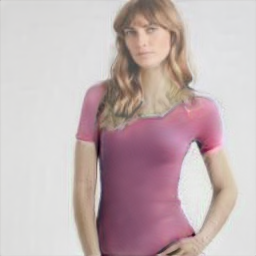

Epoch 162/500, Loss: 0.6391376256942749
Epoch 163/500, Loss: 0.6431369781494141
Epoch 164/500, Loss: 0.6595098376274109
Epoch 165/500, Loss: 0.6608911156654358
Epoch 166/500, Loss: 0.6674478054046631
Epoch 167/500, Loss: 0.6482489109039307
Epoch 168/500, Loss: 0.6613757014274597
Epoch 169/500, Loss: 0.6585161089897156
Epoch 170/500, Loss: 0.6552301645278931
Epoch 171/500, Loss: 0.6664109826087952


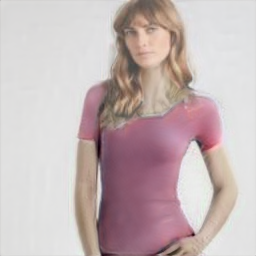

Epoch 172/500, Loss: 0.6572176814079285
Epoch 173/500, Loss: 0.6508241295814514
Epoch 174/500, Loss: 0.6499326229095459
Epoch 175/500, Loss: 0.663076639175415
Epoch 176/500, Loss: 0.670648992061615
Epoch 177/500, Loss: 0.6806399822235107
Epoch 178/500, Loss: 0.667560875415802
Epoch 179/500, Loss: 0.6772461533546448
Epoch 180/500, Loss: 0.6619179248809814
Epoch 181/500, Loss: 0.6665465831756592


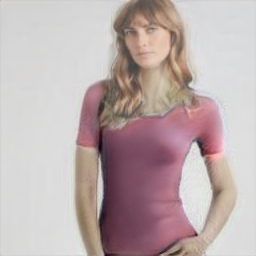

Epoch 182/500, Loss: 0.681454598903656
Epoch 183/500, Loss: 0.6985791921615601
Epoch 184/500, Loss: 0.7051605582237244
Epoch 185/500, Loss: 0.6871643662452698
Epoch 186/500, Loss: 0.6744067072868347
Epoch 187/500, Loss: 0.6681822538375854
Epoch 188/500, Loss: 0.663611650466919
Epoch 189/500, Loss: 0.6695480346679688
Epoch 190/500, Loss: 0.6620691418647766
Epoch 191/500, Loss: 0.6517634391784668


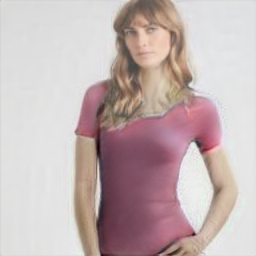

Epoch 192/500, Loss: 0.645329475402832
Epoch 193/500, Loss: 0.6429945230484009
Epoch 194/500, Loss: 0.6369861960411072
Epoch 195/500, Loss: 0.6406453251838684
Epoch 196/500, Loss: 0.655178964138031
Epoch 197/500, Loss: 0.6504972577095032
Epoch 198/500, Loss: 0.652233898639679
Epoch 199/500, Loss: 0.6454564332962036
Epoch 200/500, Loss: 0.6362667679786682
Epoch 201/500, Loss: 0.6466046571731567


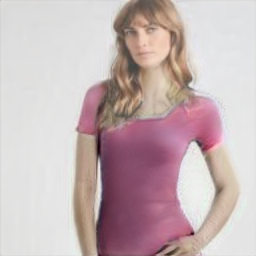

Epoch 202/500, Loss: 0.6502268314361572
Epoch 203/500, Loss: 0.6579716801643372
Epoch 204/500, Loss: 0.6549862623214722


KeyboardInterrupt: 

In [28]:
main(500, 0.05, clip_w=1, img_w=30,reg_w=1,body_shape_w=10,head_w=1,stitch=True, image_path='1.jpg',text_prompt="Grained leather crop top in vivid fuchsia pink.")
warnings.filterwarnings("ignore")

Epoch 1/500, Loss: 2.912848949432373


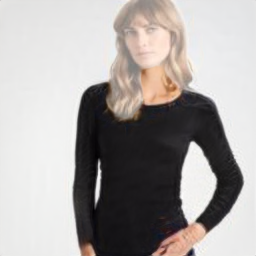

Epoch 2/500, Loss: 2.032680034637451
Epoch 3/500, Loss: 1.5149176120758057
Epoch 4/500, Loss: 1.3314695358276367
Epoch 5/500, Loss: 1.3219553232192993
Epoch 6/500, Loss: 1.3171250820159912
Epoch 7/500, Loss: 1.2593709230422974
Epoch 8/500, Loss: 1.1947839260101318
Epoch 9/500, Loss: 1.1678606271743774
Epoch 10/500, Loss: 1.1553069353103638
Epoch 11/500, Loss: 1.1608967781066895


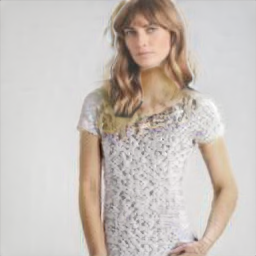

Epoch 12/500, Loss: 1.148581624031067
Epoch 13/500, Loss: 1.1474077701568604
Epoch 14/500, Loss: 1.144748330116272
Epoch 15/500, Loss: 1.1477148532867432
Epoch 16/500, Loss: 1.1536022424697876
Epoch 17/500, Loss: 1.137691617012024
Epoch 18/500, Loss: 1.104850172996521
Epoch 19/500, Loss: 1.0645804405212402
Epoch 20/500, Loss: 1.0397610664367676
Epoch 21/500, Loss: 1.0402594804763794


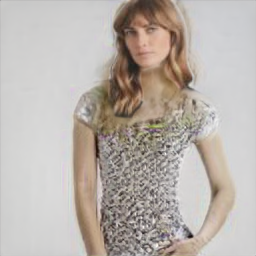

Epoch 22/500, Loss: 1.0382941961288452
Epoch 23/500, Loss: 1.0133342742919922
Epoch 24/500, Loss: 0.9928040504455566
Epoch 25/500, Loss: 0.9798642992973328
Epoch 26/500, Loss: 0.9740611910820007
Epoch 27/500, Loss: 0.9729864597320557
Epoch 28/500, Loss: 0.9628384113311768
Epoch 29/500, Loss: 0.9490262269973755
Epoch 30/500, Loss: 0.9318034052848816
Epoch 31/500, Loss: 0.9206487536430359


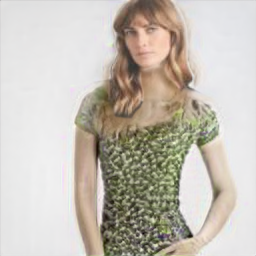

Epoch 32/500, Loss: 0.9093499183654785
Epoch 33/500, Loss: 0.9035308361053467
Epoch 34/500, Loss: 0.9055487513542175
Epoch 35/500, Loss: 0.8861930966377258
Epoch 36/500, Loss: 0.8794729709625244
Epoch 37/500, Loss: 0.8741225004196167
Epoch 38/500, Loss: 0.8713590502738953
Epoch 39/500, Loss: 0.8613541126251221
Epoch 40/500, Loss: 0.8522000312805176
Epoch 41/500, Loss: 0.8434193134307861


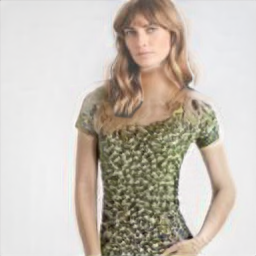

Epoch 42/500, Loss: 0.8367668986320496
Epoch 43/500, Loss: 0.825272798538208
Epoch 44/500, Loss: 0.8211756944656372
Epoch 45/500, Loss: 0.8226609826087952
Epoch 46/500, Loss: 0.8178136348724365
Epoch 47/500, Loss: 0.8048272132873535
Epoch 48/500, Loss: 0.7987267374992371
Epoch 49/500, Loss: 0.7940099239349365
Epoch 50/500, Loss: 0.7919763326644897
Epoch 51/500, Loss: 0.7911259531974792


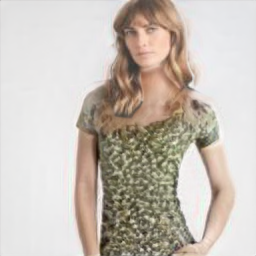

Epoch 52/500, Loss: 0.7861067652702332
Epoch 53/500, Loss: 0.7817118167877197
Epoch 54/500, Loss: 0.774932861328125
Epoch 55/500, Loss: 0.7674760818481445
Epoch 56/500, Loss: 0.7695813179016113
Epoch 57/500, Loss: 0.7689722776412964
Epoch 58/500, Loss: 0.7662867903709412
Epoch 59/500, Loss: 0.7696492075920105
Epoch 60/500, Loss: 0.7643365859985352
Epoch 61/500, Loss: 0.7627933621406555


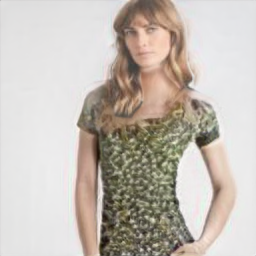

Epoch 62/500, Loss: 0.7512167692184448
Epoch 63/500, Loss: 0.7522934675216675
Epoch 64/500, Loss: 0.7477583885192871
Epoch 65/500, Loss: 0.7447951436042786
Epoch 66/500, Loss: 0.7472208142280579
Epoch 67/500, Loss: 0.7382060885429382
Epoch 68/500, Loss: 0.7286317348480225
Epoch 69/500, Loss: 0.724365770816803
Epoch 70/500, Loss: 0.7274723649024963
Epoch 71/500, Loss: 0.7251001596450806


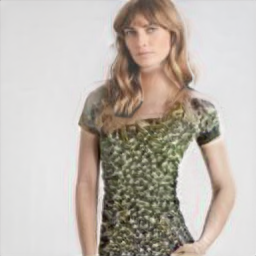

Epoch 72/500, Loss: 0.718990683555603
Epoch 73/500, Loss: 0.7266499400138855
Epoch 74/500, Loss: 0.7144825458526611
Epoch 75/500, Loss: 0.709797739982605
Epoch 76/500, Loss: 0.7056915163993835
Epoch 77/500, Loss: 0.7079127430915833
Epoch 78/500, Loss: 0.7020161747932434
Epoch 79/500, Loss: 0.7002866864204407
Epoch 80/500, Loss: 0.7003374695777893
Epoch 81/500, Loss: 0.6919277310371399


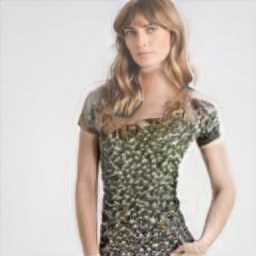

Epoch 82/500, Loss: 0.6950976252555847
Epoch 83/500, Loss: 0.7524935007095337
Epoch 84/500, Loss: 0.7655823826789856
Epoch 85/500, Loss: 0.7666017413139343
Epoch 86/500, Loss: 0.7639654278755188


KeyboardInterrupt: 

In [29]:
main(500, 0.05, clip_w=1, img_w=30,reg_w=1,body_shape_w=10,head_w=1,stitch=True, image_path='1.jpg',text_prompt="Sleeveless hand-embroidered sequin camisole featuring a camo pattern throughout in tones of green, brown, and black")
warnings.filterwarnings("ignore")